In [29]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model



In [3]:
# load datasets
dataset = load_clean_sentences('french-english-both.pkl')
train = load_clean_sentences('french-english-train.pkl')
test = load_clean_sentences('french-english-test.pkl')



In [4]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

English Vocabulary Size: 2201
English Max Length: 5


In [6]:
# prepare german tokenizer
fra_tokenizer = create_tokenizer(dataset[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1
fra_length = max_length(dataset[:, 1])
print('French Vocabulary Size: %d' % fra_vocab_size)
print('French Max Length: %d' % (fra_length))

French Vocabulary Size: 4463
French Max Length: 10


In [7]:
# prepare training data
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

In [9]:
# prepare validation data
testX = encode_sequences(fra_tokenizer, fra_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

In [10]:
# define model
model = define_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])


In [12]:
history=model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), verbose=2)




Train on 9000 samples, validate on 1000 samples
Epoch 1/30





 - 32s - loss: 4.3117 - acc: 0.4371 - val_loss: 3.5131 - val_acc: 0.4580
Epoch 2/30
 - 25s - loss: 3.3609 - acc: 0.4646 - val_loss: 3.3244 - val_acc: 0.4660
Epoch 3/30
 - 24s - loss: 3.1853 - acc: 0.4772 - val_loss: 3.2212 - val_acc: 0.4814
Epoch 4/30
 - 26s - loss: 3.0502 - acc: 0.4888 - val_loss: 3.0987 - val_acc: 0.4886
Epoch 5/30
 - 26s - loss: 2.8821 - acc: 0.5080 - val_loss: 2.9732 - val_acc: 0.5100
Epoch 6/30
 - 25s - loss: 2.7211 - acc: 0.5285 - val_loss: 2.8524 - val_acc: 0.5256
Epoch 7/30
 - 24s - loss: 2.5627 - acc: 0.5444 - val_loss: 2.7514 - val_acc: 0.5400
Epoch 8/30
 - 30s - loss: 2.4201 - acc: 0.5630 - val_loss: 2.6504 - val_acc: 0.5534
Epoch 9/30
 - 25s - loss: 2.2789 - acc: 0.5816 - val_loss: 2.5477 - val_acc: 0.5746
Epoch 10/30
 - 23s - loss: 2.1292 - acc: 0.6022 - val_loss: 2.4497 - val_acc: 0.5872
Epoch 11/30
 - 23s - loss: 1.9820 - acc: 0.6232 - val_loss: 2.3857 - val_acc: 0.5958
Epoch 12/30
 - 23s

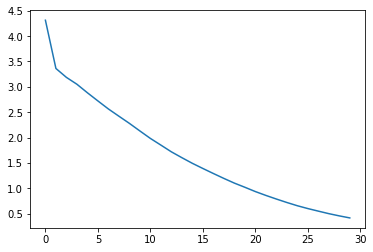

In [30]:
#print loss
plt.plot(history.history['loss'])

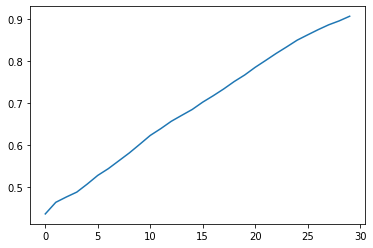

In [31]:
#print accuracy
plt.plot(history.history['acc'])

In [13]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [21]:
trainX[0]

array([  1,   2, 152, 286,   0,   0,   0,   0,   0,   0], dtype=int32)

In [28]:
#Test the translation quality
i=0
while i < 10:
    source =trainX[i]
    source = source.reshape((1, source.shape[0]))
    translation = predict_sequence(model, eng_tokenizer, source)
    print('source=[%s], target=[%s], predicted=[%s]' % (dataset[i,1], dataset[i,0], translation))
    i=i+1

source=[je suis tellement desole], target=[i am so sorry], predicted=[i am so sorry]
source=[quelle femme], target=[what a woman], predicted=[what a woman]
source=[je buvais du lait], target=[i drank milk], predicted=[i drank milk]
source=[nous sommes condamnes], target=[were doomed], predicted=[were are]
source=[je lui parlai], target=[i talked to her], predicted=[i saw to him]
source=[comment allezvous], target=[how are you], predicted=[how are you]
source=[nous avons un plan], target=[we have a plan], predicted=[we have a plan]
source=[je vois quelque chose], target=[i see something], predicted=[i see something]
source=[je suis faineante], target=[i am lazy], predicted=[im lazy lazy]
source=[reviens a toi], target=[snap out of it], predicted=[come out of it]
